## *PyTorch para Deep Learning*

O código abaixo é baseado no capítulo 2 do curso/livro on-line "Zero to Mastery Learn PyTorch for Deep Learning", disponível em <https://www.learnpytorch.io/>

## 02. PyTorch Neural Network Classification

Agora, o problema a ser analisado é um problema de classificação -- isto é, predizer se algo pertence a uma dada categoria ou não. Como é mostrada na imagem abaixo (retirada do capítulo), essa tarefa pode ter três objetivos:

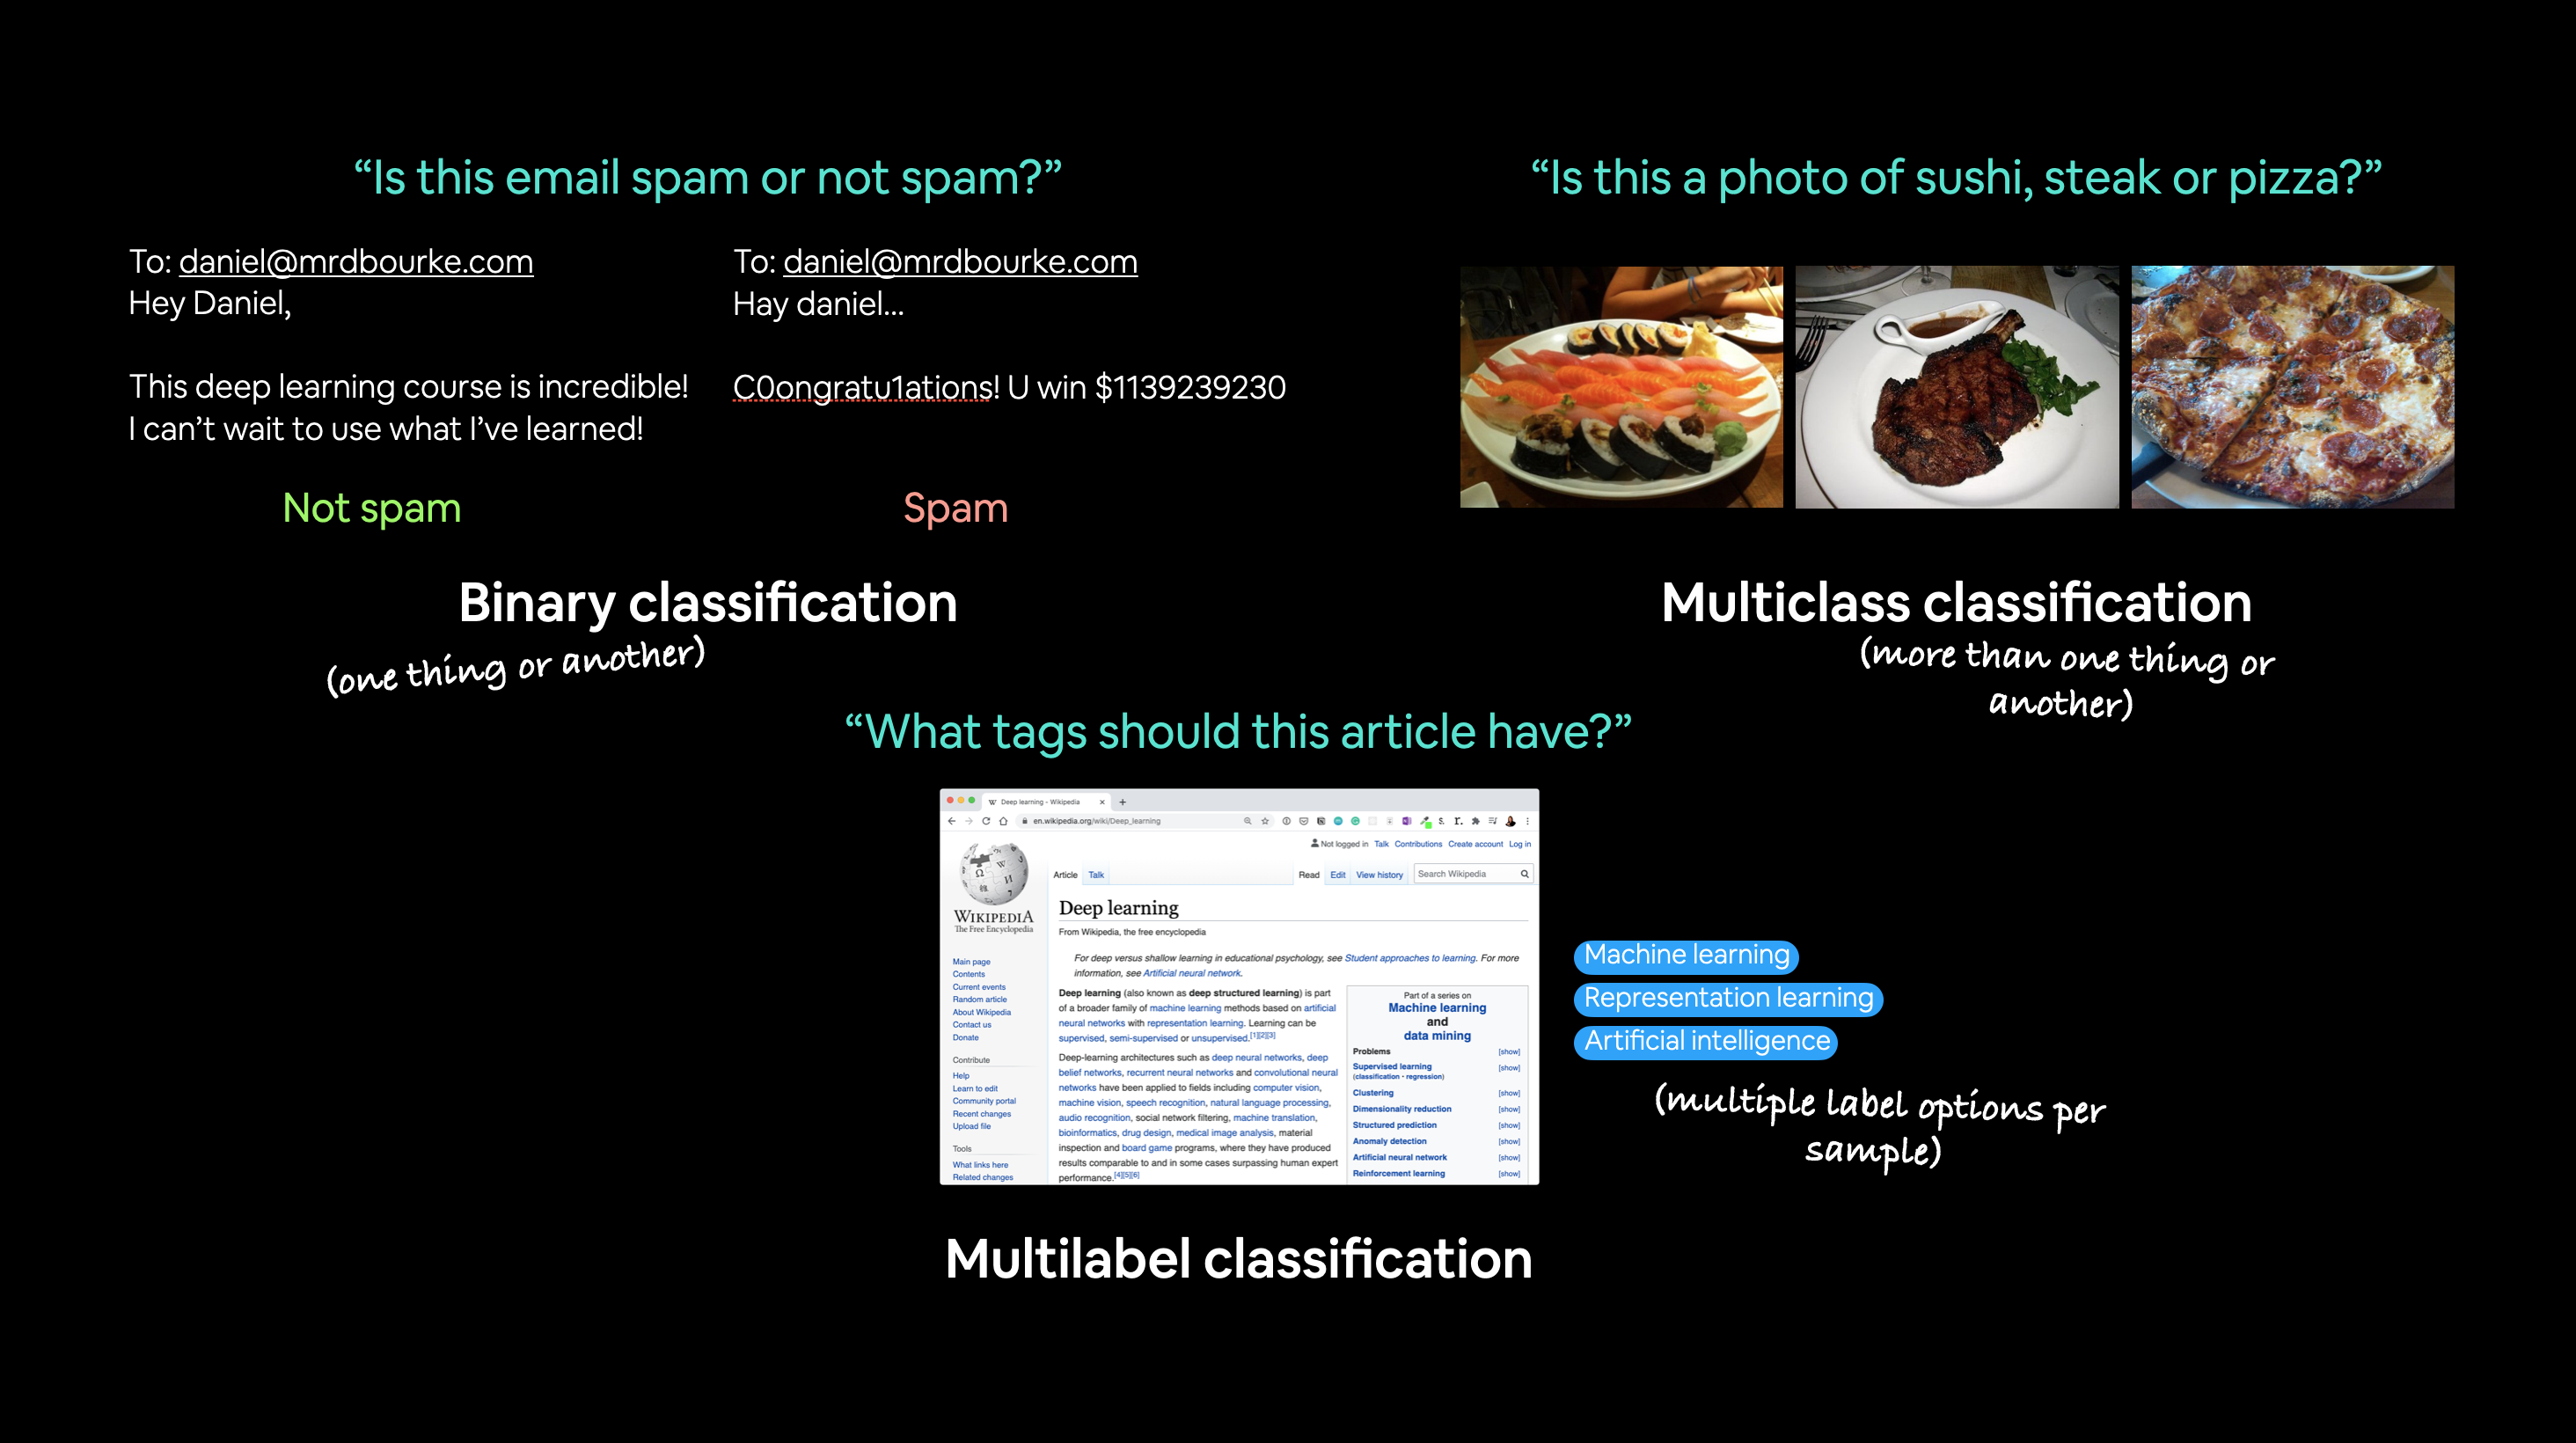

*0. Arquitetura de uma rede neural*

O site faz uma rápida introdução à arquitetura de redes neurais por meio da tabela abaixo:

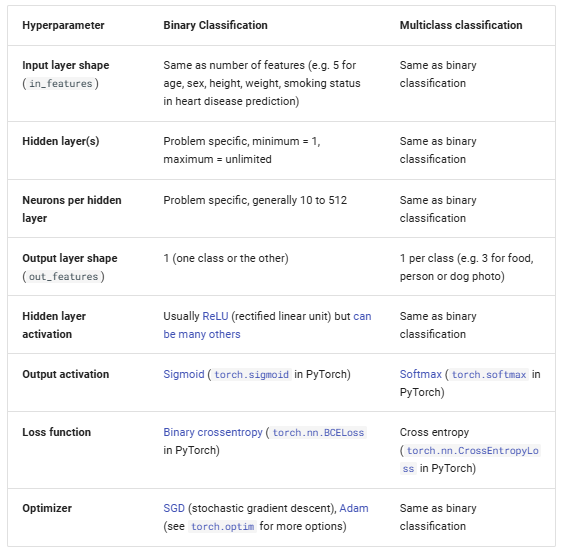

*1. Crie dados de classificação e prepare-os*

In [1]:
# inicialmente, eu vou criar dois círculos diferentes

from sklearn.datasets import make_circles

# crio 1000 amostras
n_samples = 1000

# crio os círculos
X, y = make_circles(n_samples, noise = 0.03, # para que os dados criados não sejam tão irreais
                    random_state= 42) # defino um valor de aleatoriedade para sempre conseguir os mesmos valores
                    

In [ ]:
# confiro os primeiros 5 valores de x e y
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels: \n{y[:5]}\n")

# teste pessoal para ver como make_circles funciona e qual é o seu tipo
print("formato de X: ", X.shape)
print("formato de y: ", y.shape)
 
print(f"\ntipo das variáveis X e y: {X.dtype} {y.dtype}")
# a variável X contém as coordenadas bidimensionais do ponto em um plano -> primeira posição do array indica a coordenada x,y do primeiro ponto e por aí vai
# já a variável y diz se a variável pertence a um grupo ou não

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels: 
[1 1 1 1 0]

formato de X:  (1000, 2)
formato de y:  (1000,)

tipo das variáveis X e y: float64 int64


In [3]:
# faço um DataFrame com base nos dados criados, para ajudar na visualização
import pandas as pd

# X[:, 0] mostra todas as linhas da primeira coluna e X[:, 1], da segunda (e última) coluna
# a chamada de y mostra todas as linhas de sua única coluna
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

circles.head(10) # mostra os primeiros 10 elementos dos vetores

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# confiro quantas etiquetas/labels presentes em y existem no meu conjunto de dados
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

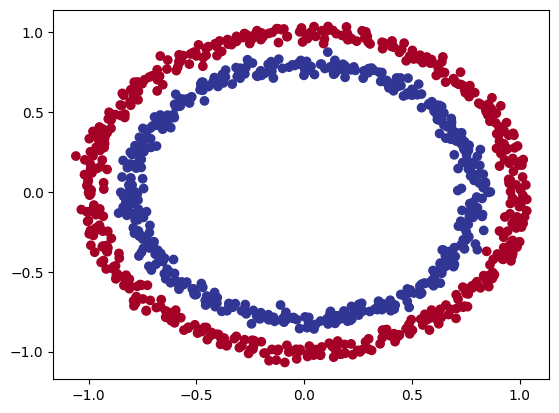

In [5]:
# visualizo os dados com um gráfico
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0], y = X[:, 1], c = y, cmap = plt.cm.RdYlBu);


Inicialmente, eu sem querer defini o noise para 0.3. Para efeitos de comparação, o gráfico resultante fica assim:

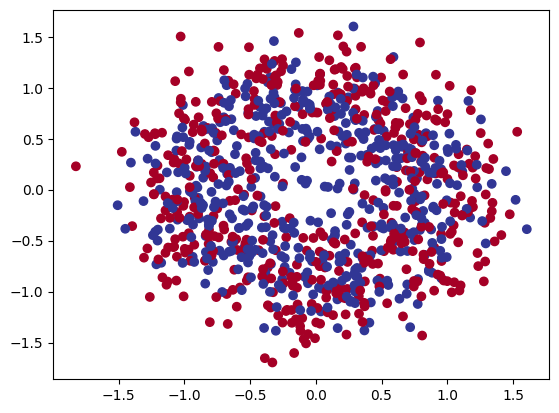

In [6]:
# confiro qual é o formato da minha entrada (X) e saída (y). O objetivo é ter esses formatos em mente
# para não realizar operações que são contrárias a esse padrão -> duas entradas para uma saída

X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# imprimo quais são os valores do primeiro elemento do array, com o objetivo de me familiarizar com esses dados
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
# transformo os meus dados de arrays numpy para tensores do pytorch, para não causar problemas futuros na computação dos dados
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# visualizo os 5 primeiros elementos de cada tensor
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# divido os meus dados em conjuntos de treino (80%) e teste (20%) com Scikit-Learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42) # escolho 42 para garantir que os resultados sejam reproduzíveis

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

*2. Construindo um modelo*

In [10]:
# importações padrão do pytorch
import torch
from torch import nn

# para garantir que o código seja device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# mesmo sendo um modelo de classificação, ele ainda é supervisionado. por isso, é necessário que ele relacione os dados de entrada com os de saída

# Passo 1: construo um classe com o modelo que é subclasse de nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Passo 2: crio as camadas – neste caso, 2 camadas nn.Linear que são capazes de lidar com as entradas e saídas de x e y (e seus formatos)
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # recebe 2 features de entrada e gera 5 de saída
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # recebe 5 features de entrada e gera 1 única saída

    # Passo 3: definir um método forward que contém a computação que será utilizada no forward pass
    def forward(self, x):
        # retorno o output da camada 2 (layer_2), que é um único feature, no mesmo formato que y
        return self.layer_2(self.layer_1(x)) # a computação vai para layer_1 primeiro e o output disso vai para layer_2
    
# Passo 4: crio uma instância do modelo e o passo para o dispositivo desejado
model_0 = CircleModelV0().to(device)
model_0

# teste pessoal para ver as camadas de model_0 -> inicialmente, os parâmetros são aleatórios
print(f"layer 1 - in features: \n{model_0.layer_1.in_features}\n") # há dois neurônios de entrada, que representam as coordenadas x, y do ponto

# as duas colunas representam os 2 features de entrada (coordenada) e as cinco linhas, os neurônios internos -> um neurônio de entrada se conecta com todos os outros neurônios internos
print(f"layer 1 - weight: \n{model_0.layer_1.weight} \n")

# o bias é uma constante adicionada ao produto do feature com o weight para ajudar o modelo a mudar a função de ativação de positivo para negativo e vice-versa -> é aplicado no neurônio
# -> fonte: https://www.turing.com/kb/necessity-of-bias-in-neural-networks:

# teste pessoal para ver o que há em cada camada
print(f"layer 1 - bias:\n {model_0.layer_1.bias} \n")
print(f"layer 1 - parameters:\n {model_0.layer_1._parameters} \n") # mostra os parâmetros completos (weight e bias)
print(f"layer 1 - out features:\n {model_0.layer_1.out_features}\n") # mostra quantos parâmetros de saída há na camada atual

print("_______________________________________________ \n")
print(f"layer 2 - in features: \n{model_0.layer_2.in_features}\n") # os 5 neurônios da camada interna são a entrada pro neurônio de saída
print(f"layer 2 - weight: \n{model_0.layer_2.weight} \n") # as 5 colunas representam cada parâmetro saíndo dos neurônios internos, há apenas uma linha, pois de cada neurônio interno sai apenas uma conexão com o neurônio de saída
print(f"layer 2 - bias:\n{model_0.layer_2.bias}\n") # há apenas um bias, pois ele é aplicado no neurônio que recebe os in_features e, neste caso, há apenas um neurônio de saída na camada externa
print(f"layer 2 - parameters:\n {model_0.layer_2._parameters} \n") # mostra os parâmetros completos (weight e bias)
print(f"layer 2 - out features:\n {model_0.layer_2.out_features}") # mostra quantos parâmetros há de saída -> no caso, apenas 1 (saída binária?)

layer 1 - in features: 
2

layer 1 - weight: 
Parameter containing:
tensor([[-0.5079, -0.5884],
        [-0.2114, -0.3860],
        [-0.2354,  0.7007],
        [ 0.6489,  0.2243],
        [-0.5833, -0.4890]], requires_grad=True) 

layer 1 - bias:
 Parameter containing:
tensor([ 0.0400, -0.5526, -0.0842,  0.0028,  0.1803], requires_grad=True) 

layer 1 - parameters:
 {'weight': Parameter containing:
tensor([[-0.5079, -0.5884],
        [-0.2114, -0.3860],
        [-0.2354,  0.7007],
        [ 0.6489,  0.2243],
        [-0.5833, -0.4890]], requires_grad=True), 'bias': Parameter containing:
tensor([ 0.0400, -0.5526, -0.0842,  0.0028,  0.1803], requires_grad=True)} 

layer 1 - out features:
 5

_______________________________________________ 

layer 2 - in features: 
5

layer 2 - weight: 
Parameter containing:
tensor([[-0.2831,  0.0024,  0.3090,  0.4193,  0.3578]], requires_grad=True) 

layer 2 - bias:
Parameter containing:
tensor([-0.2970], requires_grad=True)

layer 2 - parameters:
 {'wei

In [12]:
# replicando o código acima por meio de nn.Sequential, que aplica o forward pass nos dados de input, na ordem que as camadas aparecem
# atenção: nn.sequential >sempre< aplica as computações de maneira sequencial -- quando isso não é desejado, deve-se criar a classe (como foi feito acima) 
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# passo alguns dados pelo o modelo
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1692],
        [-0.1482],
        [-0.1493],
        [-0.1752],
        [-0.0299],
        [-0.0180],
        [-0.0533],
        [-0.0225],
        [-0.1543],
        [-0.1454]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
# crio uma função de perda (loss function, calcula o quão *errado* o modelo está) com Binary Cross Entropy, com uma camada de função sigmoide
 # -> para mais detalhes, veja: <https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a>
loss_fn = nn.BCEWithLogitsLoss() #logits em logitsloss quer dizer que a função sigmoide é aplicada ao resultado cru do modelo 

# crio um otimizador (optimizer, que melhora as predições do modelo a uma taxa de aprendizado de 0.01) com Stochastic Gradient Descent (SGD)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
# estabeleço uma métrica para avaliar o modelo e, assim, medir o quão *certo* ele está (métrica de classificação)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calcula onde dois tensores são iguais
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
# aqui, eu confiro quais são os outputs do modelo em sua forma crua -- chamados também de logits-- (o modelo ainda não foi treinado)
y_logits = model_0(X_test.to(device))[:5]
y_logits

# esse output é o resultado do método forward, que implementa duas camadas de nn.linear
# essas camadas chamam internamente a equação y = x * Weights^T (operação de transposição de W) + bias


tensor([[-0.1692],
        [-0.1482],
        [-0.1493],
        [-0.1752],
        [-0.0299]], grad_fn=<SliceBackward0>)

In [17]:
# como os números acima não estão num formato comparável com a saída esperada, nós os normalizamos através de uma função sigmoide e depois os arredondamos

# uso da função sigmoide nos logits do modelo 
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs, "\n")

# arredondo os valores resultantes para chegar no label predito (os "thresold values" são: y_pred_probs >= 0.5, y=1 (class 1); y_pred_probs < 0.5, y=0 (class 0))
y_preds = torch.round(y_pred_probs)

# comando completo
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# confiro se os dados estão batendo
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# retiro a dimensão extra
y_preds.squeeze()

tensor([[0.4578],
        [0.4630],
        [0.4627],
        [0.4563],
        [0.4925]], grad_fn=<SigmoidBackward0>) 

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [18]:
# para fins de comparação, printo y_test para ver se a dimensão dos dados é a mesma
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# agora, eu irei construir um loop de treino e teste

# configuro a quantidade de épocas -> quantidade de loops que serão executados
epochs = 100

# coloco os dados no dispostivo desejado
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# construindo o loop de treino e teste de fato
for epoch in range(epochs):
    ## Treinamento:
    model_0.train() # -> coloco o modelo no modo de treino

    # Passo 1: Forward pass (o modelo gera as saídas cruas -> logits)
    y_logits = model_0(X_train).squeeze() # o squeeze é para remover a dimensão extra '1'

    # aplico a função9 sigmoide para colocar a saída numa escala de 0 a 1, o que facilita o cálculo da probabilidade
    y_pred = torch.round(torch.sigmoid(y_logits)) # faz a operação logits -> pred probs -> pred labels

    # Passo 2: Cálculo do loss/accuracy

    # como eu estou calculando o erro da previsão feita inicialmente, essa computação gera uma saída, que também precisa 
    # ser normalizada com a função sigmoide para estar em um intervalo de 0 a 1
    loss = loss_fn(y_logits, y_train) # como eu estou usando nn.BCEWithLogitsLoss, a função sigmoide é aplicada automaticamente
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Passo 3: Os gradientes do otimizador são zerados
    optimizer.zero_grad()

    # Passo 4: Performa o cálculo de backpropagation no resultado da função de perda (loss function)
    loss.backward()

    # Passo 5: Aplica-se o otimizador no modelo, com base no cálculo de backpropagation
    optimizer.step()

    ## Testagem:
    model_0.eval() # -> coloco o modelo no modo de teste
    with torch.inference_mode(): # curiosidade: esse modo desabilita o gradiente descente, dentre outras coisas, para melhorar a performance
        # Passo 1: Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Passo 2: cálculo do loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # imprimo o que está acontecendo a cada 10 épocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") # dada a distrubuição de aprox. 50% e 50% de acertos em ambos os testes, é provável que o modelo só esteja "chutando" o resultado

Epoch: 0 | Loss: 0.69503, Accuracy: 48.00% | Test loss: 0.69476, Test acc: 48.50%
Epoch: 10 | Loss: 0.69384, Accuracy: 41.25% | Test loss: 0.69396, Test acc: 43.50%
Epoch: 20 | Loss: 0.69338, Accuracy: 46.88% | Test loss: 0.69376, Test acc: 45.00%
Epoch: 30 | Loss: 0.69318, Accuracy: 48.75% | Test loss: 0.69377, Test acc: 46.50%
Epoch: 40 | Loss: 0.69309, Accuracy: 49.00% | Test loss: 0.69383, Test acc: 49.00%
Epoch: 50 | Loss: 0.69305, Accuracy: 49.62% | Test loss: 0.69390, Test acc: 48.50%
Epoch: 60 | Loss: 0.69303, Accuracy: 50.75% | Test loss: 0.69397, Test acc: 47.50%
Epoch: 70 | Loss: 0.69301, Accuracy: 51.00% | Test loss: 0.69402, Test acc: 46.00%
Epoch: 80 | Loss: 0.69301, Accuracy: 51.12% | Test loss: 0.69408, Test acc: 46.00%
Epoch: 90 | Loss: 0.69300, Accuracy: 51.38% | Test loss: 0.69412, Test acc: 46.00%


In [ ]:
# ploto um gráfico com as predições feitas pelo modelo para descobrir como ele está organizando as classes
import requests
from pathlib import Path

# faço o download das funções de ajuda do repositório Learn PyTorch
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

ModuleNotFoundError: No module named 'torchvision'

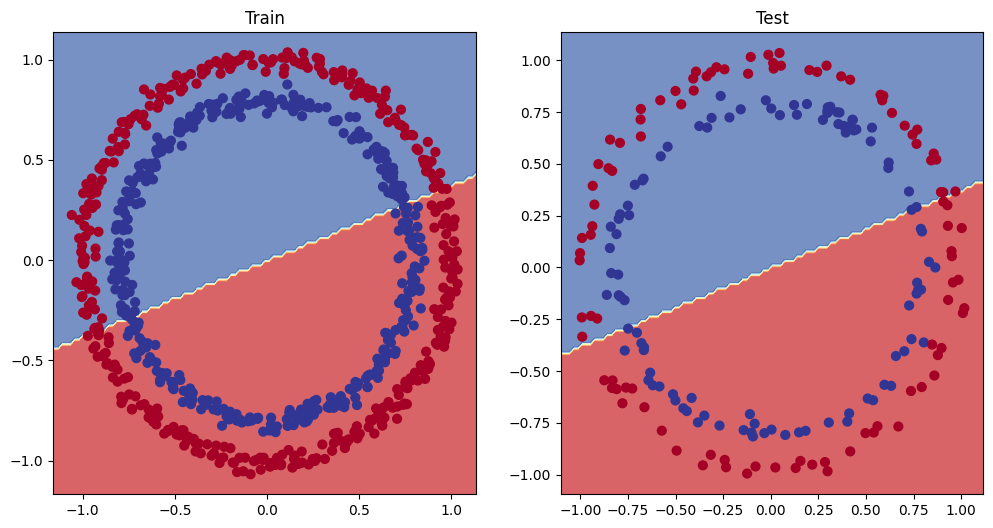

In [21]:
# com a helper function, faço o plot do limite de decisão (decision boundary) para os conjuntos de teste e treino
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

A partir dos gráficos gerados, é possível perceber que as predições do modelo estão abaixo do esperado, já que estão usando uma linha reta para dividir um conjunto de dados que é circular (o que explica a distribuição de 50%-50% dos resultados de treino e teste). Sendo assim, é necessário melhorar o modelo, tornando-o mais complexo para conseguir lidar com esse conjunto de dados

*5. Melhorando o modelo (de uma perspecitiva do modelo)* 

Formas de se melhorar um modelo, de acordo com o livro:

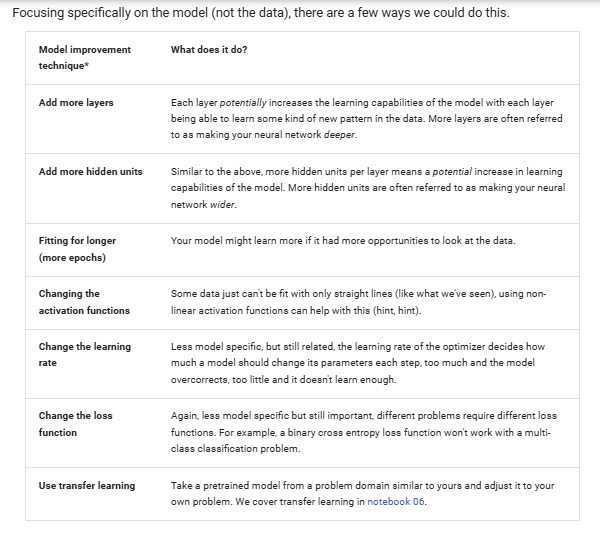

In [22]:
# agora, eu irei alterar o meu código para que ele suporte operações mais complexas e duradouras, com a esperança de que assim ele consiga prever melhor a qual conjunto os dados pertencem
# adiciono uma camada interna extra, aumento a quantidade de épocas(de 100 para 1000) e a quantidade de neurônios das camadas internas (de 5 para 10) -> as operações feitas ainda são lineares

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # layer extra
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # o passo a passo para se computar o modelo está descrito abaixo. porém, o comando único poder se beneficiar de melhorias quando é possível
        # z = self.layer_1 (x)
        # z = self.layer_2 (z)
        # z = self.layer_3(z)
        # return z

        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
# crio uma função de loss e um otimizador para esse novo modelo
loss_fn = nn.BCEWithLogitsLoss() # função sigmoide já está inclusa
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [24]:
torch.manual_seed(42)

# aplico ao loop de treino e de teste 1000 épocas, ao invés de 100
epochs = 1000

# coloco os dados de treino e teste no dispositivo desejado
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# começo o loop de treino e teste em si
for epoch in range(epochs):
    ### Treino
    model_1.train() # coloco o meu modelo no modo de treino

    # Passo 1: Forward pass
    y_logits = model_1(X_train).squeeze() # y_logits quer dizer que foi feita uma precição, porém ela não está no formato de probabilidade
    y_pred = torch.round(torch.sigmoid(y_logits)) # predição adequada ao formato de probabilidade (entre 0 e 1)

    # Passo 2: Calculo a perda/loss e acurácia
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true= y_train, y_pred= y_pred)

    # Passo 3: Os gradientes do otimizador são zerados
    optimizer.zero_grad()

    # Passo 4: Aplico o algoritmo de backpropagation
    loss.backward()

    # Passo 5: Otimizo as predições com base no que o algoritmo de backpropagation calculou
    optimizer.step()

    ### Teste
    model_1.eval() # coloco o modelo no modo de teste
    with torch.inference_mode():

        # Passo 1: Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Passo 2: Calculo o loss e a acurácia
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true= y_test, y_pred= test_pred)

    # Imprimo o que está acontecendo a cada 10 épocas
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69354, Accuracy: 50.25% | Test loss: 0.69348, Test acc: 49.00%
Epoch: 100 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69437, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69456, Test acc: 45.50%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69463, Test acc: 45.50%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69467, Test acc: 45.50%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


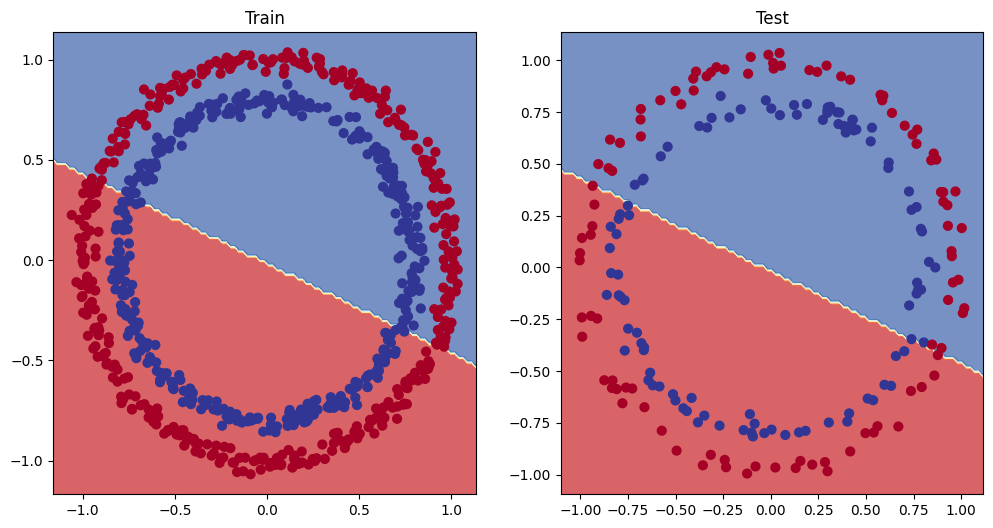

In [25]:
# ploto as "decision boundaries" dos conjuntos de treino e teste
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

A partir dos gráficos acima, é possível perceber que o modelo está separando os conjuntos de maneira linear (devido a linha branca como decision boundary), por ele próprio ser um modelo linear, mesmo após aumentar a quantidade de camadas internas e épocas

In [26]:
# com o objetivo de checar a suposição feita acima – de que o modelo é linear – tento ver se o modelo consegue gerar uma linha reta a partir de alguns dados

# crio os dados (como no capítulo passado)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# crio o x e o y
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # fórmula de regressão linear

# confiro os dados que criei 
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# crio os conjuntos de treino e teste
train_split = int(0.8 * len(X_regression)) # 80% dos dados são usados para treino e 20%, para teste
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split] # x e y de treino recebem 80% dos valores de x e y regression
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:] # x e y de teste recebem os 20% finais dos valores de x e y regression

# checo o tamanho de cada divisão feita
print(len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression))

80 80 20 20


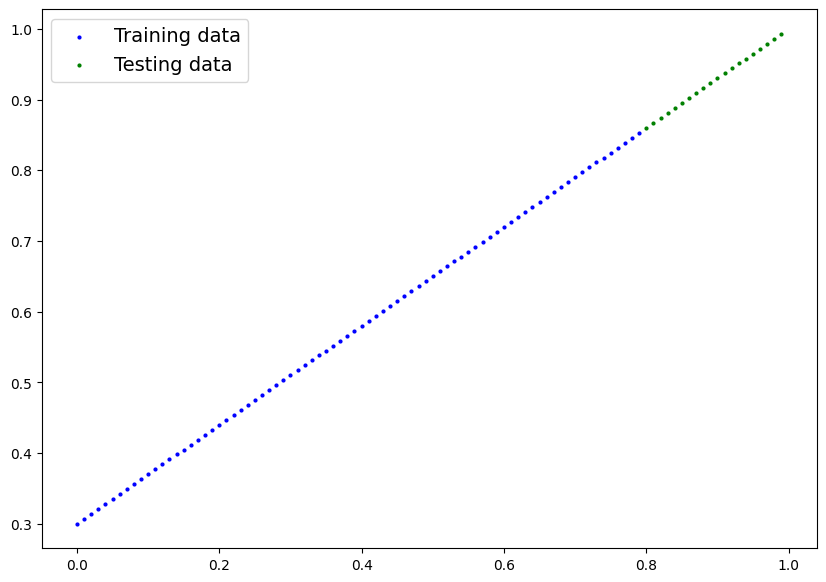

In [28]:
# ploto os dados de treino e teste para ver como estão organizados
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [29]:
# ajusto o model_1 para caber em uma linha reta (o nn.sequential faz o mesmo que a definir uma classe, porém obrigatoriamente aplica os métodos de maneira sequencial)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# defino a função de loss e o otimizador para o model_2
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [31]:
# refaço o loop do model_1, para ver se ele de fato é um modelo linear

torch.manual_seed(42)

epochs = 1000

# coloco os dados no dispositivo alvo
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# começo o loop de treino e teste
for epoch in range(epochs):
    ### Treino
    model_2.train()

    # Passo 1: Forward pass
    y_pred = model_2(X_train_regression)

    # Passo 2: Calculo a loss function (não preciso de calcular a acurácia, pois agora estamos tratando de um problema de regressão)
    loss = loss_fn(y_pred, y_train_regression)

    # Passo 3: Zero os gradientes do otimizador
    optimizer.zero_grad()

    # Passo 4: Performo backpropagation
    loss.backward()

    # Passo 5: Atualizo o otimizador
    optimizer.step()

    ### Teste
    model_2.eval()
    with torch.inference_mode():
        # Passo 1: Forward pass
        test_pred = model_2(X_test_regression)

        # Passo 2: Calculo a loss function
        test_loss = loss_fn(test_pred, y_test_regression) # test_pred é o verdadeiro e y_test_regression é a predição

    # imprimo o que está acontecendo de 10 em 10 épocas
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


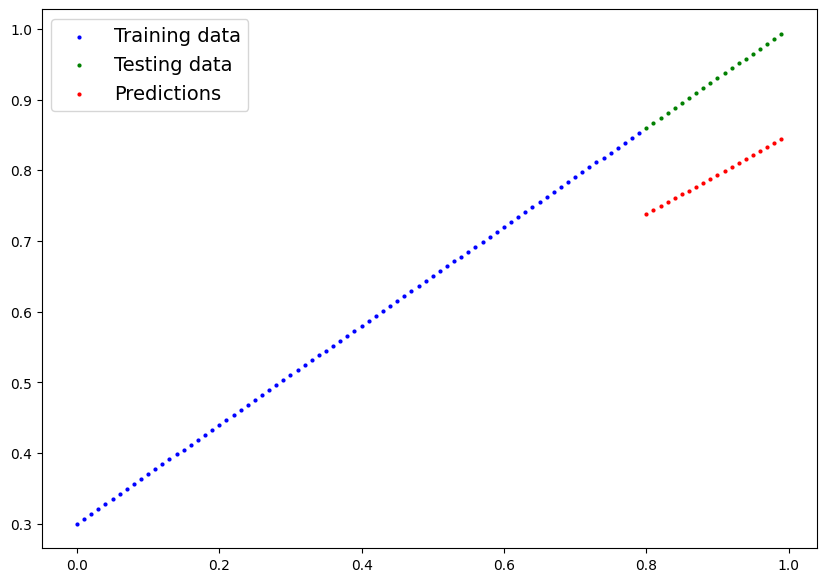

In [32]:
# coloco o modelo no modo de avaliação
model_2.eval()

# faço *apenas* as predições novamente (sem atualizá-las), para salvar na variável e utilizar esta para medir a diferença entre o conjunto de teste e o resultado calculado
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# imprimo os dados e as predições com os dados na CPU, pois o matplotlib não consegue lidar com os dados na GPU
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

Como é demonstrado acima, o modelo atual consegue, sim, aprender e fazer inferências, porém elas são definitivamente lineares. Assim, é necessário não apenas aumentar a quantidade de camadas internas ou a quantidade de épocas, mas mudar a forma como o modelo *em si* funciona e quais computações faz – ou seja, alterar o modelo para que ele se torne não linear.

Uma dica dada pelo livro a respeito disso: "A helpful troubleshooting step when *building deep learning models is to start as small as possible to see if the model works before scaling it up.*

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount of data or the model size/design to reduce overfitting."

*6.  A peça faltante: não-linearidade*

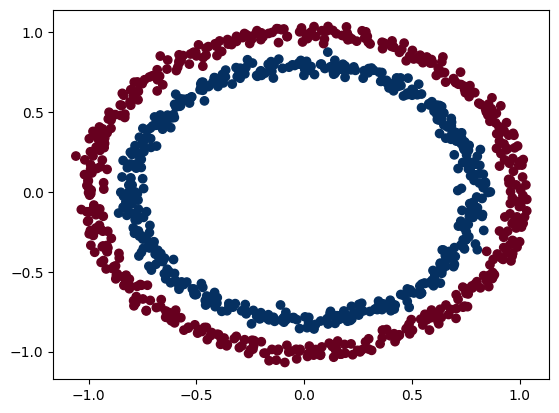

In [33]:
# recrio os dados para começar do zero
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.RdBu);

In [34]:
# converto os dados para tensores (já que o pytorch lida melhor com eles) e divido-os em conjuntos de treino e teste
import torch
from sklearn.model_selection import train_test_split

# transformo os dados de numpy arrays para tensores
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# divido os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [35]:
# para lidar com a não-linearidade dos dados, eu coloco uma função de ativação entre as camadas internas do modelo
# essa função de ativação é posta no método forward, pois ela será calculada entre um neurônio e outro da camada (A -> função -> B)
# a função escolhida foi a Rectified Linear-Unit, também conhecida como ReLu (definida como max(0, x), sendo x o neurônio de entrada, mais simples que a sigmoide)
#   -> para saber mais sobre funções de ativação, não linearidade e ReLu, veja: <https://www.geeksforgeeks.org/activation-functions-neural-networks/>


# construo o modelo com uam função de ativação não linear
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # adiciono ReLu como função de ativação

    def forward(self, x):
        # ReLu entremeada entre as camadas de neurônios
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_3 = CircleModelV2().to(device)
print(model_3)
 

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [36]:
# crio a função de loss e o otimizador
loss_fn = nn.BCEWithLogitsLoss() # já contém a função sigmoide para normalizar o resultado da conta
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

In [37]:
# ajusto o modelo
torch.manual_seed(42)
epochs = 1400

# coloco todos os dados no dispositivo desejado
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
     ### Treino
    model_3.train()
    
    # Passo 1: forward pass
    y_logits = model_3(X_train).squeeze() # resultado sem estar normalizado (entre 0 e 1)
    y_pred = torch.round(torch.sigmoid(y_logits)) # resultado normalizado com função sigmoide -> predição da probabilidade

    # Passo 2: cálculo da loss function e da acurácia
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Passo 3: os gradientes do otimizador são zerados
    optimizer.zero_grad()

    # Passo 4: Backpropagation
    loss.backward()

    # Passo 5: Atualizo o otimizador com base no que foi calculado no backpropagation
    optimizer.step()

    ### Teste
    model_3.eval()
    with torch.inference_mode():
        # Passo 1: forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # a predição feita passa a ter o formato de uma probabilidade, entre 0 e 1

        # Passo 2: cálculo da loss function e da acurácia
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # imprimo o que está acontecendo de 100 em 100 épocas
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

In [38]:
# vejo se as predições estão no formato certo
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

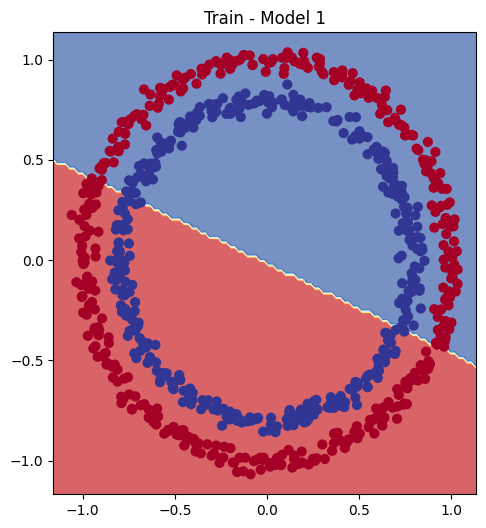

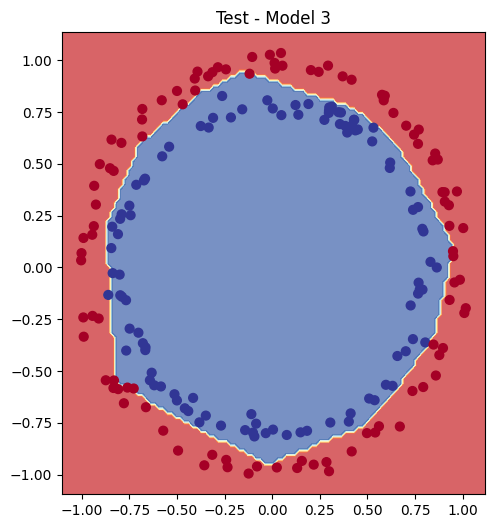

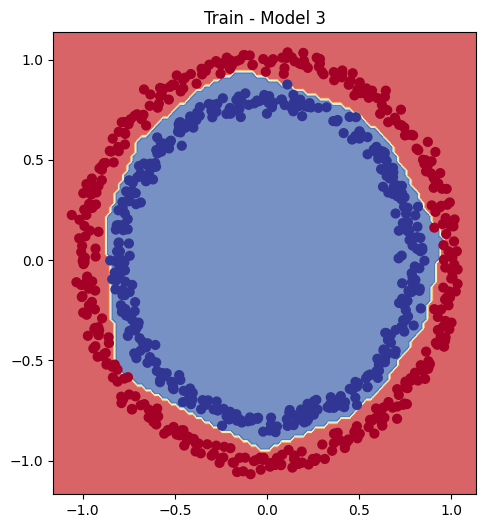

In [39]:
# ploto a decision boudary para os conjuntos de treino e teste do modelo 1 e do modelo 3
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train - Model 1")
plot_decision_boundary(model_1, X_train, y_train) # modelo inicial, que era completamente linear

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 2)
plt.title("Test - Model 3")
plot_decision_boundary(model_3, X_test, y_test) # modelo atual, é capaz de fazer predições não lineares

# teste pessoal para ver como foi o treino
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train - Model 3")
plot_decision_boundary(model_3, X_train, y_train)

Condições de teste e treino iniciais do modelo 3:

-> Épocas = 1000

-> Camada inicial: 2 neurônios

-> 2 camada internas: 10 neurônios cada

-> Camada de saída: 1 neurônio

-> Função de ativação: ReLU

Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%

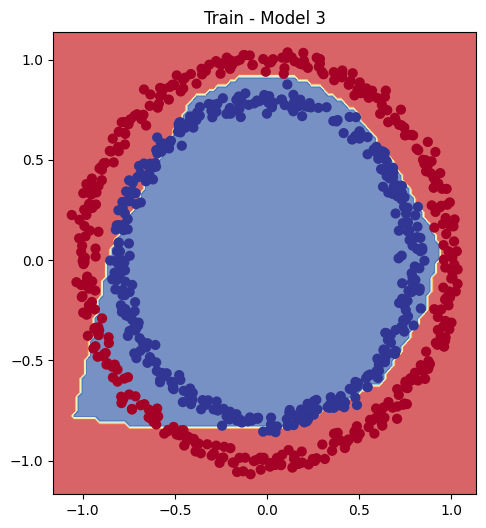 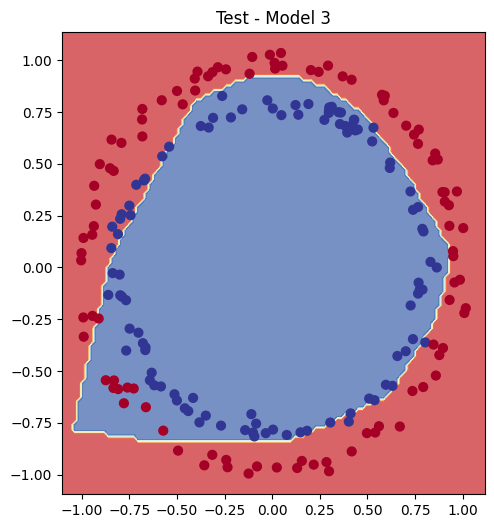

Teste pessoal para melhoria do modelo:

1ª Alteração: Mudança da quantidade de épocas para 1200 (o resto não foi alterado)

Epoch: 1100 | Loss: 0.48153, Accuracy: 93.50% | Test Loss: 0.49935, Test Accuracy: 90.50%

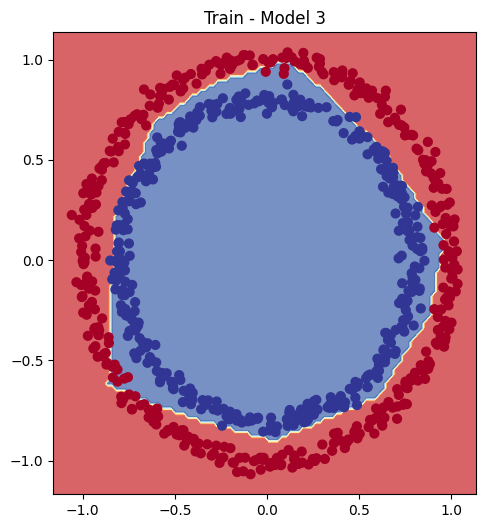 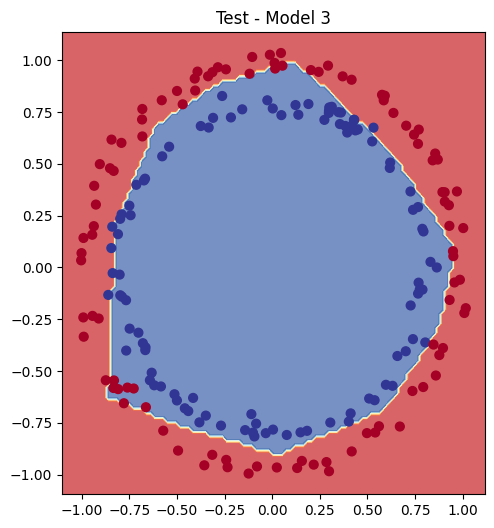

2ª Alteração: Mudança da quantidade de épocas para 1400 (o resto não foi alterado)

Epoch: 1300 | Loss: 0.25458, Accuracy: 99.00% | Test Loss: 0.30333, Test Accuracy: 96.50%

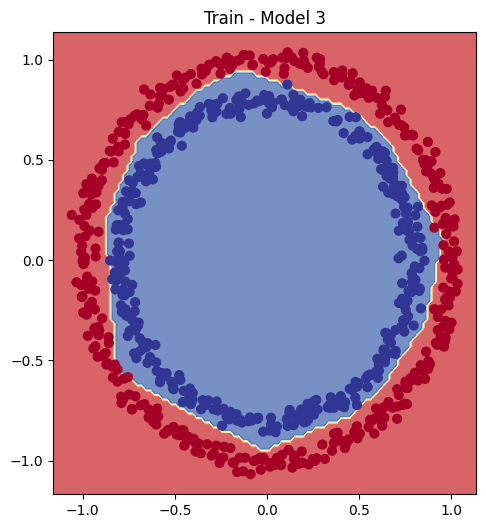  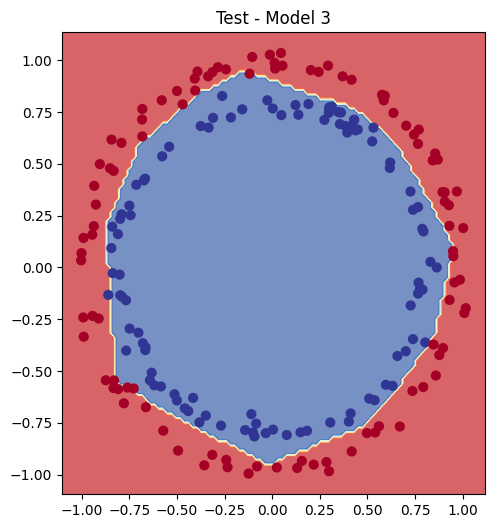

*7. Replicando funções de ativação não-lineares*

In [40]:
# crio um conjunto de dados para simular os modelos não-lineares com eles (toy tensor)
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

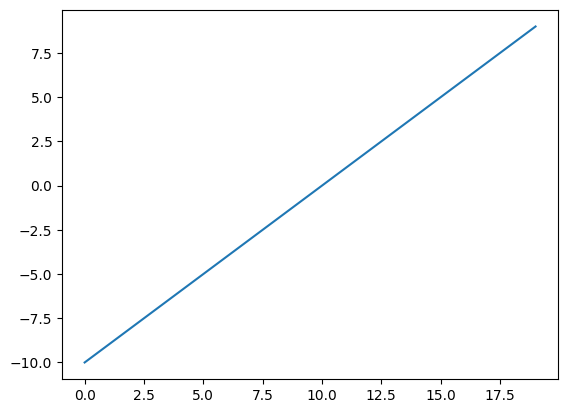

In [41]:
# visualizando os dados
plt.plot(A)

In [42]:
# crio a função de ativação Rectified Linear Unit (ReLU) à mão
def relu(x):
    return torch.maximum(torch.tensor(0), x) # comparo os dois tensores

# passo os dados criados para a ReLU
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

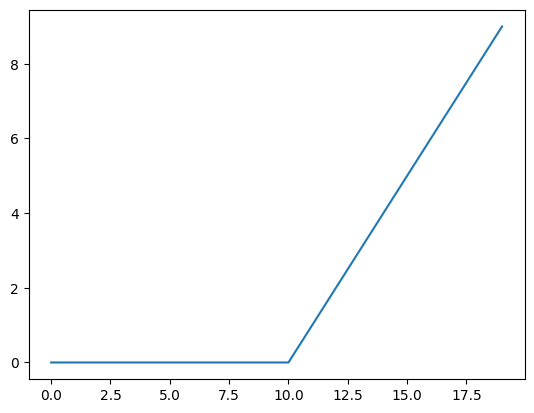

In [44]:
# ploto o gráfico gerado pela aplicação da ReLU em A
plt.plot(relu(A))

In [45]:
# crio a função de ativação sigmoide à mão:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


# testo a função sigmoide nos dados criados
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

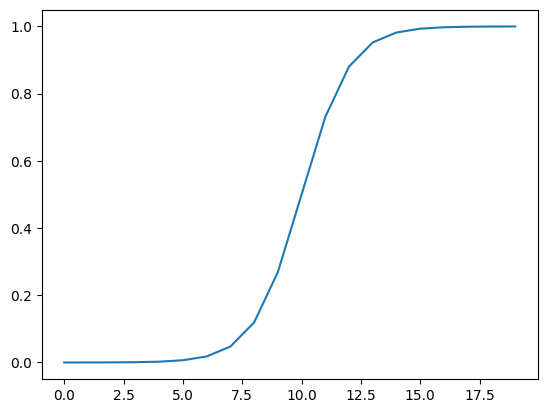

In [46]:
# ploto o resultado da aplicação da função sigmoide em A
plt.plot(sigmoid(A))

*8. Juntando essas informações construindo um modelo multiclasse em PyTorch*

Agora, o modelo criado será capaz de classificar quais são as classes presentes em um conjunto de dados (ou seja, é um modelo de classificação que lida com "clusters")

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


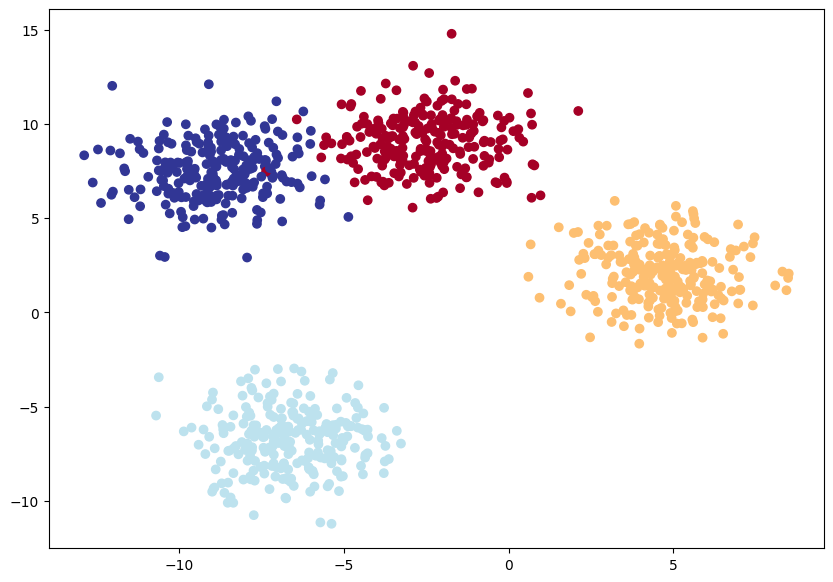

In [30]:
# importo as dependências para criar os dados para as multiclasses com o método make_blobs()
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# configuro os hiperparâmetros para a criação dos dados
NUM_CLASSES = 4 # número de classes/clusters que há nos dados
NUM_FEATURES = 2 # coordenadas cartesianas
RANDOM_SEED = 42

# Passo 1: crio os dados multi-classe
X_blob, y_blob = make_blobs(n_samples = 1000, # número total de pontos, que será dividido igualmente entre as classes
                            n_features=NUM_FEATURES, # rótulos/"labels" relativos ao X
                            centers=NUM_CLASSES, # rótulos/"labels" relativos ao y 
                            cluster_std=1.5, # atua como o nível de ruído/"noise" nos dados
                            random_state=RANDOM_SEED # defino o nível de aleatoriedade dos dados
                            )
# Passo 2: transformo esses dados em tensores do PyTorch (originalmente, eles são arrays do NumPy, mas o PyTorch não lida muito bem com isso)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# Passo 3: divido os dados em conjuntos de treino e teste
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size = 0.2, random_state = RANDOM_SEED)

# Passo 4: imprimo os dados em um gráfico
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

In [ ]:
#